In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from load_data import Data
from models import LogisticRegressor, Model, Analytics, LinearCombo, SVMClassifier
from sklearn.linear_model import LogisticRegression
import os
import pickle
import copy

## **Load Data**

In [9]:
data = Data()

pc_path = r"/media/joshua/Expansion1/tst/BaseLearnerInference"

training_images = [f"{a:03d}" for a in range(1, 33)]
all_images = [f"{a:03d}" for a in range(1, 41)]
testing_images = [f"{a:03d}" for a in range(33, 41)]

models = ["BasicPlans", "DA5_Segmentations", "LargeEncoder"] 

seg_path = os.path.join(pc_path, "Probabilities")
gt_path = os.path.join(pc_path, "GroundTruths")

data.get_simple_segmentations(seg_path, all_images, ".npz")
data.get_groundtruths(gt_path)



In [11]:
data.simple_data["001"]["BasicPlans"]

array([[[4.64743971e-05, 2.24740888e-05, 3.52184179e-05, ...,
         3.59130136e-05, 1.87046680e-05, 2.84097441e-05],
        [6.22933367e-05, 2.43002396e-05, 3.59130136e-05, ...,
         2.72148991e-05, 1.31604511e-05, 1.84146847e-05],
        [7.87448589e-05, 3.21923326e-05, 4.38296447e-05, ...,
         3.60535669e-05, 1.79179897e-05, 2.02245374e-05],
        ...,
        [9.35104690e-05, 2.43953455e-05, 2.37373388e-05, ...,
         3.73435687e-05, 2.65844828e-05, 5.87484210e-05],
        [7.22608238e-05, 2.03036943e-05, 1.92984062e-05, ...,
         2.93115372e-05, 2.07041376e-05, 4.73909786e-05],
        [4.00636927e-05, 1.62509368e-05, 1.80585193e-05, ...,
         2.40171430e-05, 1.85591089e-05, 3.67646353e-05]],

       [[3.56335440e-05, 1.45672702e-05, 1.96790261e-05, ...,
         1.15687963e-05, 6.00184603e-06, 1.07412725e-05],
        [8.25235984e-05, 4.72062275e-05, 6.40200669e-05, ...,
         4.19863100e-05, 1.43975585e-05, 9.59088811e-06],
        [9.87662061e-05, 

In [3]:
model_segs = {model: {} for model in models}
for model in models:
    for image in testing_images:

        model_segs[model][image] = data.simple_data[image][model]



## **Logistic Regression**

In [6]:
logreg = LogisticRegressor(data.simple_data, data.gts, models)

In [ ]:
def test_alpha(alpha, balanced=False):
    log_params = {'C': alpha}
    if balanced:
        log_params['class_weight'] = "balanced"
    dice = []
    for i in range(1, 33):
        train_fold = [k for k in training_images if k != f"{i:03d}"]
        logreg.train_model(train_fold, log_params)
        result = logreg.predict([f"{i:03d}"])
        analytics = Analytics(result, data.gts)
        dice.append(analytics.dice_coefficients())
        
    with open(f'pickles/dice_results_C_{alpha:.6f}_balanced.pkl', 'wb') as f:
        pickle.dump({'C': alpha, 'dice_scores': dice}, f)
    
    return dice


In [ ]:
# This grid searches for balanced/unbalanced
dices_balanced = {}
for a in np.linspace(-3, 3, 21):
    alpha = 10 ** a
    dice = test_alpha(alpha)
    dices_balanced[a] = dice


In [7]:
# If the grid search has already been completed can load in the pickles

balanced_results = {}
unbalanced_results = {}

for file in os.listdir("pickles/"):
    with open(f"pickles/{file}", 'rb') as f:
        data = pickle.load(f)
    key = data["C"]
    scores = data["dice_scores"][0]
    mean_score = np.mean(list(scores.values()))

    if "balanced" in file:
        balanced_results[key] = mean_score
    else:
        unbalanced_results[key] = mean_score



In [9]:
def get_max_from_dict(results_dict, dict_name=""):
    if not results_dict:
        print(f"Dictionary {dict_name} is empty")
        return None, None
    
    max_key = max(results_dict, key=results_dict.get)
    max_value = results_dict[max_key]
    
    if dict_name:
        print(f"Best {dict_name} - C: {max_key}, Dice: {max_value:.4f}")
    
    return max_key, max_value

# Usage:
balanced_max_key, balanced_max_val = get_max_from_dict(balanced_results, "Balanced")
unbalanced_max_key, unbalanced_max_val = get_max_from_dict(unbalanced_results, "Unbalanced")

Best Balanced - C: 0.001, Dice: 0.9732
Best Unbalanced - C: 3.1622776601683795e-05, Dice: 0.9725


In [4]:
logreg = LogisticRegressor(data.simple_data, data.gts, models)
params = {"C": 0.001, "class_weight": "balanced"}
logreg.train_model(training_images, params)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.001
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [8]:
logreg.segmentation_data['001'].keys()

dict_keys(['BasicPlans', 'DA5_Segmentations', 'LargeEncoder'])

In [5]:
logreg.model.coef_

array([[1.73857108, 4.32985273, 3.24451672]])

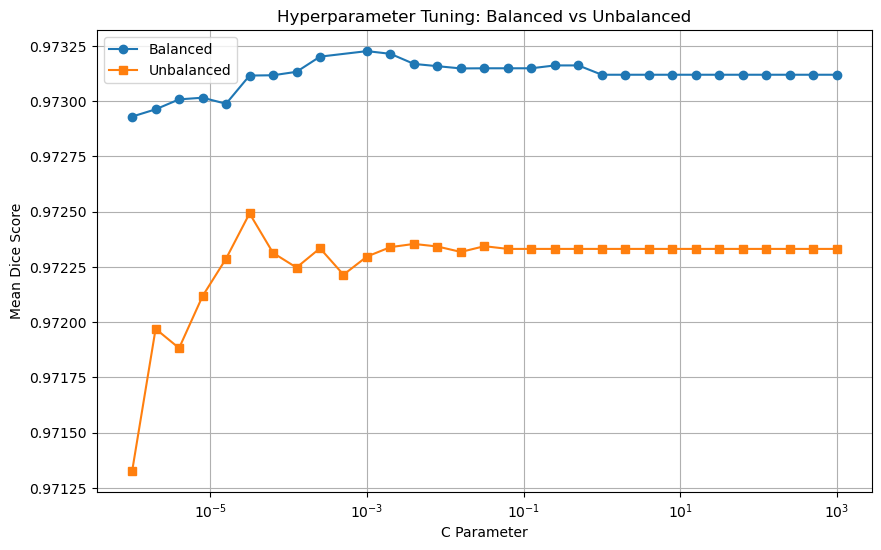

In [6]:
balanced_sorted = sorted(balanced_results.items())
unbalanced_sorted = sorted(unbalanced_results.items())

plt.figure(figsize=(10, 6))
plt.plot([k for k, v in balanced_sorted], [v for k, v in balanced_sorted], 'o-', label='Balanced')
plt.plot([k for k, v in unbalanced_sorted], [v for k, v in unbalanced_sorted], 's-', label='Unbalanced')
plt.xlabel('C Parameter')
plt.ylabel('Mean Dice Score')
plt.title('Hyperparameter Tuning: Balanced vs Unbalanced')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

### **SVM**

In [4]:
def test_svm_params(C, kernel='rbf', balanced=False):
    svm_params = {'C': C, 'kernel': kernel}
    if balanced:
        svm_params['class_weight'] = "balanced"
    
    dice = []
    
    # Create 11 folds with 3 images each
    for fold in range(11):
        test_fold = [f"{i:03d}" for i in range(1, 33) if (i-1) % 11 == fold]
        train_fold = [k for k in training_images if k not in test_fold]
        
        svm.train_model(train_fold, svm_params)
        result = svm.predict(test_fold)
        analytics = Analytics(result, data.gts)
        dice.append(analytics.dice_coefficients())
    
    kernel_name = kernel if not balanced else f"{kernel}_balanced"
    with open(f'pickles/svm_results_C_{C:.6f}_{kernel_name}.pkl', 'wb') as f:
        pickle.dump({'C': C, 'kernel': kernel, 'balanced': balanced, 'dice_scores': dice}, f)
    
    return dice

In [ ]:
svm = SVMClassifier(data.simple_data, data.gts, models)

# Test SVM with specific parameters
dice_results = test_svm_params(C=1.0, kernel='linear', balanced=False)
print(f"SVM results completed. Dice scores shape: {len(dice_results)}")
